<a href="https://colab.research.google.com/github/sayanbanerjee32/multimodal_llm/blob/main/multimodal_inference_test_with_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/openai/CLIP.git
# !pip install transformers==4.44.2
!pip install -Uq transformers accelerate peft

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qelp08gi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qelp08gi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=983720253a7180059633c4c2c37e83a456d9d4728e169eb4c9611d0c2cb57335
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqloi4j9/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from peft import PeftModel
# from audio_pipeline import AudioTranscriptionPipeline
import clip
from PIL import Image
import os
import json
import random
from huggingface_hub import hf_hub_download
import torch.nn as nn
import gc

In [ ]:
# from huggingface_hub import HfApi

# api = HfApi()
# api.upload_folder(
#     folder_path='/content/drive/MyDrive/multimodel_llm/merged_phi3_llava_model',
#     repo_id="sayanbanerjee32/multimodal-phi3-4k-instruct-llava",
#     repo_type="model",
#     delete_patterns = "*.safetensors",
#     # allow_patterns = "*.safetensors",
# )
# print("Model uploaded to Hugging Face Hub")

In [ ]:
import subprocess
import os

def download_files():
    # URLs to download
    coco_url = "http://images.cocodataset.org/zips/train2017.zip"
    coco_zip = "train2017.zip"
    coco_dir = "train2017"
    llava_url = "https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json"
    llava_json = "llava_instruct_150k.json"

    # Download COCO dataset
    if not os.path.exists(coco_zip):
        print("Downloading COCO train2017 dataset...")
        subprocess.run(["wget", "-c", coco_url])
    else:
        print("COCO dataset already downloaded.")

    # Unzip COCO dataset
    if not os.path.exists(coco_dir):
        print("Unzipping the dataset...")
        subprocess.run(["unzip", "-q", coco_zip])
    else:
        print("COCO dataset already unzipped.")

    # Download LLaVA 150k instruction JSON file
    if not os.path.exists(llava_json):
        print("Downloading LLaVA 150k instruction JSON file...")
        subprocess.run(["wget", "-c", llava_url])
    else:
        print("LLaVA 150k instruction JSON file already downloaded.")

    print("All files have been downloaded and extracted.")

# Call the function to download files
download_files()

Unzipping the dataset...
All files have been downloaded and extracted.


In [ ]:
import json
import random

def prepare_dataset(conversations):
    # Assuming conversations is a list of dictionaries with 'from' and 'value' keys
    # Process the conversations to create a single text input
    processed_text = ""
    expected_gt = ""
    for conv in conversations:
        if conv['from'] == 'human':
            processed_text += f"Human: {conv['value']}\n"
            break
    for conv in conversations:
        if conv['from'] == 'gpt':
            expected_gt += f"Assistant: {conv['value']}\n"
        # elif conv['from'] == 'gpt':
        #     processed_text += f"Assistant: {conv['value']}\n"
    return processed_text.strip(), expected_gt.strip()

def select_random_sample(json_file, coco_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Select a random sample
    sample = random.choice(data)
    image_name = sample['image']
    conversations = sample['conversations']

    # Process the text using the prepare_dataset function
    text, expected_op = prepare_dataset(conversations)

    # Construct the image path
    image_path = os.path.join(coco_dir, image_name)

    return image_path, text, expected_op

# Example usage
image_path, text, expected_op = select_random_sample("llava_instruct_150k.json", "train2017")
print(f"Selected image: {image_path}")
print(f"Corresponding text: {text}")
print(f"Expected output: {expected_op}")

Selected image: train2017/000000305885.jpg
Corresponding text: Human: <image>
How many police officers are riding horses in the image?
Expected output: Assistant: There are two police officers riding horses in the image.
Assistant: The officers are riding their horses on a cobblestone road.
Assistant: Near the officers and horses, there are pedestrians on one side of the street and parked bicycles on the other side.
Assistant: The horses that the police officers are riding are brown.
Assistant: There are several possible reasons for police officers patrolling on horseback in the area depicted in the image:

1. High visibility: Officers on horseback are more visible due to their elevated position compared to officers on foot or in patrol cars. This allows them to better monitor and observe the surroundings, identify disturbances or illegal activities, and provide a greater sense of security for the public.

2. Crowd control: Horses can be used effectively for crowd control during events

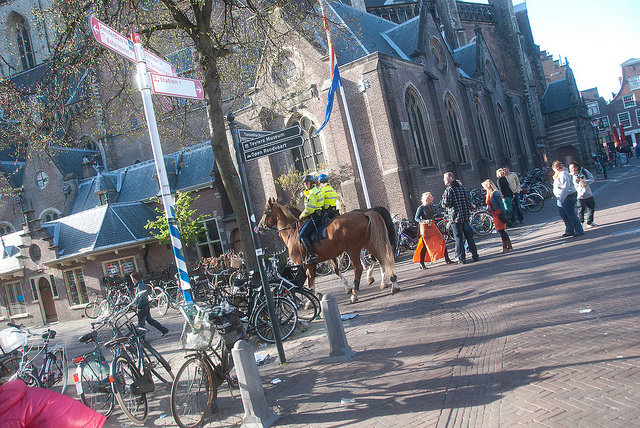

In [ ]:
## lets see the image
img = Image.open(image_path)
display(img)

## Load model and generate

In [3]:
import gc
gc.collect()

0

In [2]:
class ImageProjector(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1024):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.GELU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.05)

        # Store initial weights for both layers
        self.register_buffer('initial_weights1', self.layer1.weight.data.clone())
        self.register_buffer('initial_weights2', self.layer2.weight.data.clone())

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

    def get_weight_change(self):
        current_weights1 = self.layer1.weight.data
        current_weights2 = self.layer2.weight.data

        # Ensure all tensors are on the same device
        device = current_weights1.device
        initial_weights1 = self.initial_weights1.to(device)
        initial_weights2 = self.initial_weights2.to(device)

        weight_diff1 = torch.norm(current_weights1 - initial_weights1).item()
        weight_diff2 = torch.norm(current_weights2 - initial_weights2).item()
        return weight_diff1 + weight_diff2  # Total weight change across both layers

class Phi3WithProjector(PreTrainedModel):
    supports_gradient_checkpointing = True
    _supports_sdpa = True # Add this line

    def __init__(self, phi3_model, projector, debug=False):
        super().__init__(phi3_model.config)
        self.phi3 = phi3_model
        self.projector = projector
        self.debug = debug

    def debug_print(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, debug=False, **kwargs):
        # Load the base Phi-3 model
        phi3_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)

        # Determine if it's a local path or a Hugging Face model ID
        is_local = os.path.isdir(pretrained_model_name_or_path)

        if is_local:
            projector_path = os.path.join(pretrained_model_name_or_path, "image_projector.pth")
        else:
            try:
                # Try to download the projector weights from the Hugging Face Hub
                projector_path = hf_hub_download(repo_id=pretrained_model_name_or_path, filename="image_projector.pth")
            except Exception as e:
                print(f"Failed to download projector weights: {e}")
                projector_path = None

        if projector_path and os.path.exists(projector_path):
            projector_state_dict = torch.load(projector_path, map_location=phi3_model.device)
            # Check if the state dict has the expected structure
            if 'linear.weight' in projector_state_dict:
                input_dim = projector_state_dict['linear.weight'].size(1)
                output_dim = projector_state_dict['linear.weight'].size(0)
            else:
                # If not, try to infer dimensions from the first layer's weight
                first_key = next(iter(projector_state_dict))
                input_dim = projector_state_dict[first_key].size(1)
                output_dim = phi3_model.config.hidden_size  # Assuming this is the correct output dimension

            projector = ImageProjector(input_dim, output_dim)

            # Try to load the state dict, ignoring mismatched keys
            projector.load_state_dict(projector_state_dict, strict=False)
            print(f"Loaded projector with input_dim={input_dim}, output_dim={output_dim}")
        else:
            print(f"Projector weights not found. Initializing with default dimensions.")
            input_dim = 512  # Default CLIP embedding size
            output_dim = phi3_model.config.hidden_size
            projector = ImageProjector(input_dim, output_dim)

        # Move the projector to the same device as phi3_model
        projector = projector.to(phi3_model.device)

        # Create and return the Phi3WithProjector instance
        model = cls(phi3_model, projector, debug=debug)
        return model

    def save_pretrained(self, save_directory):
        print(f"Saving model to {save_directory}")

        # Save the base model
        self.phi3.save_pretrained(save_directory)

        # Save the projector weights
        projector_path = os.path.join(save_directory, "image_projector.pth")
        projector_state = self.projector.state_dict()
        print(f"Projector weights stats before saving:")
        for name, param in projector_state.items():
            print(f"  {name}: mean={param.mean().item():.4f}, std={param.std().item():.4f}")
        torch.save(projector_state, projector_path)

        # Save the config
        self.config.save_pretrained(save_directory)

        print(f"Model saved successfully to {save_directory}")

    def forward(self, input_ids=None, attention_mask=None, labels=None, image_embeddings=None, past_key_values=None, **kwargs):
        device = next(self.parameters()).device

        if image_embeddings is not None:
            projected_embeddings = self.projector(image_embeddings)
            # Ensure projected_embeddings requires grad
            if not projected_embeddings.requires_grad:
                projected_embeddings.requires_grad_(True)
            projected_embeddings = projected_embeddings.unsqueeze(1)
            self.debug_print(f"forward projected_embeddings: {projected_embeddings.size()}")

            if past_key_values is None:  # This is the first forward pass
                self.debug_print(f"forward before: {attention_mask.size() if attention_mask is not None else None}")
                if 'inputs_embeds' in kwargs and kwargs['inputs_embeds'] is not None:
                    inputs_embeds = kwargs['inputs_embeds']
                    self.debug_print(f"forward before inputs_embeds: {inputs_embeds.size()}")
                    inputs_embeds = torch.cat([projected_embeddings, inputs_embeds], dim=1)
                    kwargs['inputs_embeds'] = inputs_embeds
                    self.debug_print(f"forward after inputs_embeds: {inputs_embeds.size()}")
                elif input_ids is not None:
                    self.debug_print(f"forward input_ids: {input_ids.size()}")
                    inputs_embeds = self.get_input_embeddings()(input_ids.to(device))
                    self.debug_print(f"forward before inputs_embeds: {inputs_embeds.size()}")
                    inputs_embeds = torch.cat([projected_embeddings, inputs_embeds], dim=1)
                    self.debug_print(f"forward after inputs_embeds: {inputs_embeds.size()}")
                    kwargs['inputs_embeds'] = inputs_embeds
                    input_ids = None  # Set to None to avoid conflict

                if attention_mask is not None:
                    attention_mask = torch.cat([torch.ones(image_embeddings.size(0), 1, device=device), attention_mask.to(device)], dim=1)
                else:
                    attention_mask = torch.ones(image_embeddings.size(0), inputs_embeds.size(1), device=device)

                if labels is not None:
                    # Adjust labels to match the new sequence length
                    labels = torch.cat([torch.full((labels.size(0), 1), -100, device=device), labels], dim=1)

        if labels is not None:
            labels = labels.to(device)

        # Determine sequence length
        if 'inputs_embeds' in kwargs and kwargs['inputs_embeds'] is not None:
            seq_length = kwargs['inputs_embeds'].size(1)
        elif input_ids is not None:
            seq_length = input_ids.size(1)
        else:
            seq_length = attention_mask.size(1) if attention_mask is not None else None

        if seq_length is None:
            raise ValueError("Unable to determine sequence length. Provide either input_ids, inputs_embeds, or attention_mask.")

        # Ensure attention_mask matches the sequence length
        if attention_mask is not None:
            attention_mask = attention_mask[:, :seq_length]

        self.debug_print(f"forward final: input_ids shape: {input_ids.shape if input_ids is not None else None}")
        self.debug_print(f"forward final: attention_mask shape: {attention_mask.shape if attention_mask is not None else None}")
        self.debug_print(f"forward final: inputs_embeds shape: {kwargs.get('inputs_embeds', {}).shape if kwargs.get('inputs_embeds') is not None else None}")

        return self.phi3(input_ids=input_ids, attention_mask=attention_mask, labels=labels, past_key_values=past_key_values, **kwargs)

    def prepare_inputs_for_generation(self, input_ids, past=None, attention_mask=None, **kwargs):
        inputs = self.phi3.prepare_inputs_for_generation(input_ids, past=past, attention_mask=attention_mask, **kwargs)

        if 'image_embeddings' in kwargs:
            inputs['image_embeddings'] = kwargs['image_embeddings']

            if past is None:  # First forward pass
                # Adjust attention_mask to account for the image token
                if attention_mask is not None:
                    inputs['attention_mask'] = torch.cat([torch.ones((attention_mask.size(0), 1), device=attention_mask.device), attention_mask], dim=1)
            else:  # Subsequent passes
                # Ensure attention_mask matches the current sequence length
                if attention_mask is not None:
                    current_seq_length = past[0][0].size(2) + 1  # past key's sequence length + 1 for the new token
                    inputs['attention_mask'] = attention_mask[:, :current_seq_length]

            inputs.pop('position_ids', None)

        # Safe printing of shapes
        self.debug_print(f"prepare_inputs_for_generation: input_ids shape: {inputs['input_ids'].shape if 'input_ids' in inputs else None}")
        self.debug_print(f"prepare_inputs_for_generation: attention_mask shape: {inputs['attention_mask'].shape if 'attention_mask' in inputs else None}")
        self.debug_print(f"prepare_inputs_for_generation: inputs_embeds shape: {inputs.get('inputs_embeds', {}).shape if inputs.get('inputs_embeds') is not None else None}")

        return inputs

    def get_input_embeddings(self):
        return self.phi3.get_input_embeddings()

    def set_input_embeddings(self, value):
        self.phi3.set_input_embeddings(value)

    def gradient_checkpointing_enable(self, **kwargs):
        self.phi3.gradient_checkpointing_enable(**kwargs)

    def gradient_checkpointing_disable(self):
        self.phi3.gradient_checkpointing_disable()

    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.phi3, name)

    def generate(self, input_ids=None, attention_mask=None, image_embeddings=None, **kwargs):
        if image_embeddings is not None:
            kwargs['image_embeddings'] = image_embeddings
            self.debug_print(f"generate input_ids: {input_ids.size()}")
            self.debug_print(f"generate image_embedding: {image_embeddings.size()}")

        if attention_mask is not None and image_embeddings is not None:
            # Add an extra attention mask token for the image embedding
            self.debug_print(f"generate before: {attention_mask.size()}")
            attention_mask = torch.cat([torch.ones(attention_mask.size(0), 1, device=attention_mask.device), attention_mask], dim=1)
            self.debug_print(f"generate after: {attention_mask.size()}")

        return super().generate(input_ids=input_ids, attention_mask=attention_mask, **kwargs)


In [3]:
class MultimodalInference:
    def __init__(self, model_name, tokenizer_name, peft_model_path=None, clip_model_name="ViT-B/32", debug=False):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.debug = debug

        # Load the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        # Load the model
        if peft_model_path:
             # If a PEFT adapter is provided, load the base model and merge with the adapter
            base_model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
                low_cpu_mem_usage=True
            )
            peft_model = PeftModel.from_pretrained(base_model, peft_model_path)
            merged_model = peft_model.merge_and_unload()

            # Load the projector separately if it exists
            projector_path = f"{peft_model_path}/projector.pth"
            if os.path.exists(projector_path):
                projector_state_dict = torch.load(projector_path, map_location=self.device)
                input_dim = projector_state_dict['linear.weight'].size(1)
                output_dim = projector_state_dict['linear.weight'].size(0)
                projector = ImageProjector(input_dim, output_dim)
                projector.load_state_dict(projector_state_dict)
            else:
                # If projector doesn't exist, initialize with default dimensions
                input_dim = 512  # Default CLIP embedding size
                output_dim = merged_model.config.hidden_size
                projector = ImageProjector(input_dim, output_dim)

            # Create Phi3WithProjector instance
            self.model = Phi3WithProjector(merged_model, projector, debug=self.debug)
        else:
            # If no PEFT adapter is provided, load the pre-merged model
            self.model = Phi3WithProjector.from_pretrained(
                model_name,
                debug=self.debug
            )
        print(self.model)
        # Move the model to the appropriate device
        self.model = self.model.to(self.device)

        # Load CLIP model
        self.clip_model, self.clip_preprocess = clip.load(clip_model_name, device=self.device)

        # Initialize the audio transcription pipeline if needed
        # self.audio_pipeline = AudioTranscriptionPipeline()

    def debug_print(self, *args, **kwargs):
        if self.debug:
            print(*args, **kwargs)

    def process_image(self, image_path):
        image = self.clip_preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            image_embedding = self.clip_model.encode_image(image).squeeze()
        return image_embedding

    def process_audio(self, audio_file):
        # Use the __call__ method of AudioTranscriptionPipeline
        transcription = self.audio_pipeline(audio_file)
        return transcription

    def multimodal_inference(self, text_input, image_path=None, audio_file=None):
        dialogue = [{"role": "system", "content": "You are a helpful assistant."}]

        prompt = "Given the following information, provide a detailed and accurate response:\n"

        if text_input:
            prompt += f"{text_input}\n"
        else:
            prompt += "Please describe what you observe in the provided media.\n"

        if image_path is not None:
            prompt += "[An image is provided for this task.]\n"

        # if audio_file is not None:
            # audio_transcription = self.process_audio(audio_file)
            # prompt += f"[AUDIO TRANSCRIPTION: {audio_transcription}]\n"

        dialogue.append({"role": "user", "content": prompt})

        # Apply chat template without adding the end token
        inputs = self.tokenizer.apply_chat_template(dialogue, return_tensors="pt", add_generation_prompt=True)

        # Remove the last token if it's the end-of-text token
        if inputs[0][-1] == self.tokenizer.eos_token_id:
            inputs = inputs[:, :-1]

        # Print the decoded input to verify the prompt structure
        print("Decoded input:")
        print(self.tokenizer.decode(inputs[0]))

        input_ids = inputs.to(self.device)
        attention_mask = torch.ones_like(input_ids)

        image_embedding = None
        if image_path is not None:
            image_embedding = self.process_image(image_path)

        if image_embedding is not None:
            image_attention = torch.ones((input_ids.size(0), 1), dtype=torch.long, device=self.device)
            self.debug_print(f"multimodal_inference input_ids: {input_ids.size()}")
            self.debug_print(f"multimodal_inference image_embedding: {image_embedding.size()}")
            self.debug_print(f"multimodal_inference before: {attention_mask.size()}")
            attention_mask = torch.cat([image_attention, attention_mask], dim=1)
            self.debug_print(f"multimodal_inference after: {attention_mask.size()}")

        with torch.no_grad():
            if image_embedding is not None:
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    image_embeddings=image_embedding.unsqueeze(0),
                    max_new_tokens=150,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.8,
                    top_k=40,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    no_repeat_ngram_size=3,
                    pad_token_id=self.tokenizer.eos_token_id,
                    use_cache=True,
                )
            else:
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    # max_new_tokens=100,
                    # num_return_sequences=1,
                    # do_sample=True,
                    # temperature=0.7,
                    # top_k=50,
                    # top_p=0.95,
                    max_new_tokens=150,
                    num_return_sequences=1,
                    do_sample=True,
                    temperature=0.8,
                    top_k=40,
                    top_p=0.9,
                    repetition_penalty=1.2,
                    no_repeat_ngram_size=3,
                    pad_token_id=self.tokenizer.eos_token_id,
                    use_cache=True,
                )

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [8]:
# Initialize the inference class with pre-merged model
hf_inference = MultimodalInference(
    model_name= "sayanbanerjee32/multimodal-phi3_5-mini-instruct-llava",
    # 'sayanbanerjee32/multimodal-phi3-4k-instruct-llava',
    tokenizer_name="sayanbanerjee32/multimodal-phi3_5-mini-instruct-llava"
)

tokenizer_config.json:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:  83%|########3 | 4.13G/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

image_projector.pth:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

<ipython-input-4-21a1281d021f>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projector_state_dict = torch.load(projector_path, map_location=phi3_model.device)


Loaded projector with input_dim=512, output_dim=3072
Phi3WithProjector(
  (phi3): Phi3ForCausalLM(
    (model): Phi3Model(
      (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-31): 32 x Phi3DecoderLayer(
          (self_attn): Phi3SdpaAttention(
            (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
            (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
            (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
          )
          (mlp): Phi3MLP(
            (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
            (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
            (activation_fn): SiLU()
          )
          (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
          (resid_attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_mlp_dropout): Dropout(p=0.0, inplace=Fa

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 72.5MiB/s]


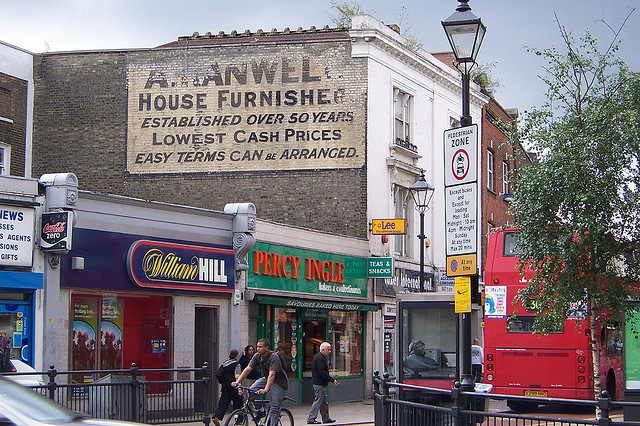

In [5]:
## local images
image_path = '1.png'
img = Image.open(image_path)
display(img)

In [6]:
text = "Can you describe the main features of this image for me?"

In [11]:
# Perform inference with pre-merged model
generated_text_merged = hf_inference.multimodal_inference(
    text_input=text,
    image_path=image_path
)

print("Generated text (pre-merged model):")
print(generated_text_merged)

Decoded input:
<|system|> You are a helpful assistant.<|end|><|user|> Given the following information, provide a detailed and accurate response:
Can you describe the main features of this image for me?
[An image is provided for this task.]
<|end|><|assistant|>


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


Generated text (pre-merged model):
You are a helpful assistant. Given the following information, provide a detailed and accurate response:
Can you describe the main features of this image for me?
[An image is provided for this task.]
 I'm sorry but as an AI text-based model developed by Microsoft, currently there isn’t any capability to directly view or analyze images through your input here in our conversation format which uses only written language inputs/outputs (text). However! If descriptive details about it were shared with respecting its content - color schemes used; notable subjects present within if human figures exist etc.; whether background scenery indicates indoor versus outdoor scenes like urban landscapes vs nature settings could be considered aspects that would aid someone else into understanding what they might see on such imaginary picture based upon these descriptions alone..  For more precise insights regarding specific visual elements please consider describing the

In [7]:
gc.collect()

56

In [9]:
# Initialize a new inference class with PEFT adapter
peft_inference = MultimodalInference(
    model_name='microsoft/Phi-3.5-mini-instruct',
    tokenizer_name='microsoft/Phi-3.5-mini-instruct',
    peft_model_path='/content/drive/MyDrive/multimodal_llm/phi-3_5/checkpoints/final_model',  # Adjust this path as needed
    debug=False  # Enable debug mode to see more information
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3WithProjector(
  (phi3): Phi3ForCausalLM(
    (model): Phi3Model(
      (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-31): 32 x Phi3DecoderLayer(
          (self_attn): Phi3SdpaAttention(
            (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
            (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
            (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
          )
          (mlp): Phi3MLP(
            (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
            (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
            (activation_fn): SiLU()
          )
          (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
          (resid_attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
          (post_attention_layernorm): Phi3RMSNor

In [10]:

# Perform inference with PEFT adapter
generated_text_peft = peft_inference.multimodal_inference(
    text_input=text,
    image_path=image_path
)

print("\nGenerated text (PEFT adapter):")
print(generated_text_peft)

Decoded input:
<|system|> You are a helpful assistant.<|end|><|user|> Given the following information, provide a detailed and accurate response:
Can you describe the main features of this image for me?
[An image is provided for this task.]
<|end|><|assistant|>


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)



Generated text (PEFT adapter):
You are a helpful assistant. Given the following information, provide a detailed and accurate response:
Can you describe the main features of this image for me?
[An image is provided for this task.]
 I'm sorry, but as an AI language model text-based interface developed by Microsoft (Philip Chen), currently there isn’t any capability to directly perceive or analyze images within your input texts; however if descriptors were given about that specific picture here would be my approach in describing its details based on those descriptions : 
  1) **Subject** - Firstly mention who/what might appear prominently at focus area e., animals like 'a lion', vehicles such ‘an ambulance,' people named characters from movies etc depending upon contextual hints present with description . This will help set up scene setting initially giving clues into what kind genre it could belong too i.-e wildlife
